In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore')

In [3]:
from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Влияние разброса данных в пределах коэф. вариации на качество прогноза Кригинга
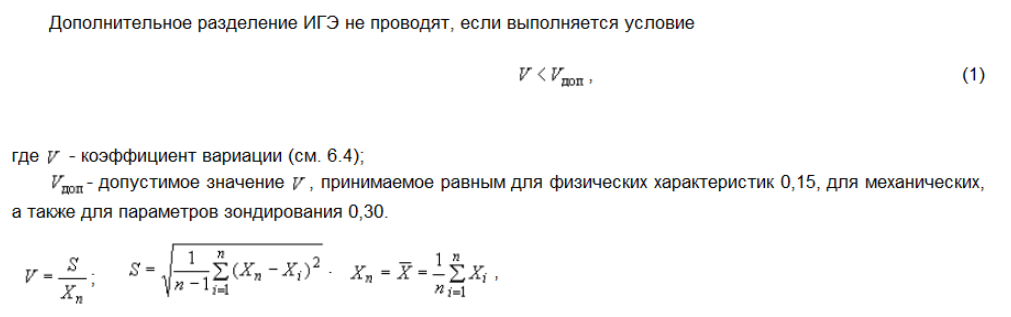

## Влияние шума в данных на Кригинг на примере случайных данных

### Линейный тренд данных
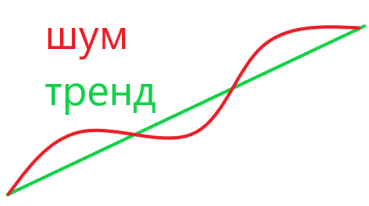

In [98]:
def linear_func(k, b):
    def func(x):
        return k*x + b
    
    return func

In [99]:
count_value = 300
model = 'exponential'
np.random.seed(123)

V_list = [.1, .3]
k_list = [.05, .1, 0.5, 1]
mean_trend_list = [1, 10, 20, 30, 50, 70, 100]

data = np.array([[0] * count_value,
                 range(count_value),
                 [0] * count_value
                 ]
                ).T

result_r2 = np.zeros((len(V_list)*len(mean_trend_list)*len(k_list), 4))

index_r2 = 0

for k in k_list:
    func_now = linear_func(k, 0)
    
    for V in V_list:
        for mean_trend in mean_trend_list:
            std_trend = mean_trend * V
            
            data[:, 2] = func_now(data[:, 1]) + np.random.normal(mean_trend, std_trend, count_value)
            data_train, data_test = train_test_split(data, test_size=.3, random_state=123)
            
            x = data_train[:, 0]
            y = data_train[:, 1]
            z = data_train[:, 2]
            
            UK = UniversalKriging(x, y, z, variogram_model=model)    
            predict, ss = UK.execute('points', data_test[:, 0].astype('float64'), data_test[:, 1])
    
            result_r2[index_r2, :] = [k, V, mean_trend, r2_score(data_test[:, 2], predict)]
            index_r2 += 1

df_r2 = pd.DataFrame(result_r2, columns=["k", "V", "mean", "r2"])

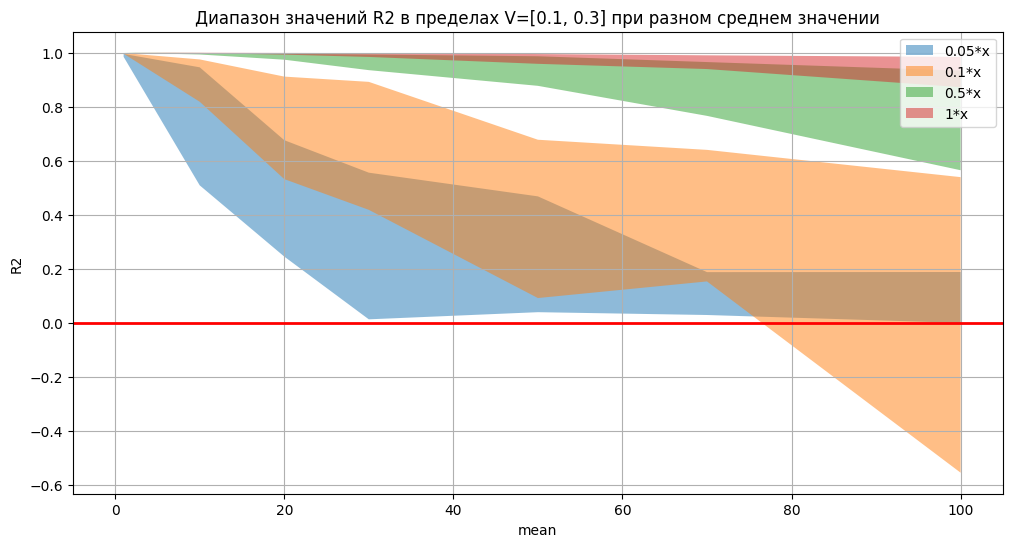

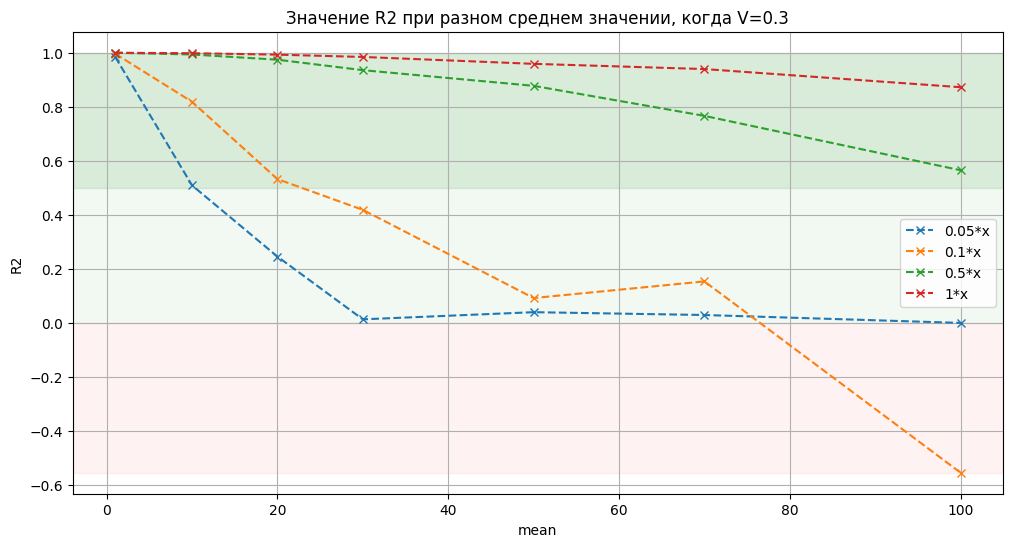

In [100]:
plt.figure(figsize=(12, 6))
plt.grid()
plt.title("Диапазон значений R2 в пределах V=[0.1, 0.3] при разном среднем значении")
plt.xlabel("mean")
plt.ylabel("R2")
plt.axline((0, 0), (mean_trend_list[-1], 0), linewidth=2, color='r')

for k in k_list:
    df_1 = df_r2.query('(V == .1) & (k == @k)')
    df_2 = df_r2.query('(V == .3) & (k == @k)')
    plt.fill_between(df_1["mean"], df_1["r2"], df_2["r2"], alpha=0.5, label=f'{k}*x')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
plt.grid()
plt.title("Значение R2 при разном среднем значении, когда V=0.3")
plt.xlabel("mean")
plt.ylabel("R2")
plt.axhspan(0, df_r2["r2"].min(), color='red', alpha=0.05)
plt.axhspan(1, 0, color='green', alpha=0.05)
plt.axhspan(1, 0.5, color='green', alpha=0.1)

for k in k_list:
    df_now = df_r2.query('(V == .3) & (k == @k)')
    plt.plot(df_now["mean"], df_now["r2"], "--x", label=f"{k}*x")
plt.legend()
plt.show()

## Вывод
    -При оценки качества модели, когда данные имеют константное среднее значение (M(x)=const), R2 близко к 0. 
    -При прогнозировании линейного тренда M(x)=kx, R2 (коэф. детерминации) падает с понижением k и увеличением дисперсии в пределах V=0.3 (коэф. вариации).
    
    -R2 > 0.5 достигается при k>=0.5 и mean<=100 (среднее значение шума), также при k>=0.1 и mean<=20 (среднее значение шума).
    -При всех k R2>0 при mean<=30.

    

# В разработке

In [5]:
def get_V(values):
    S = np.std(values, ddof=1)
    Xn = np.mean(values)
    return S/Xn

In [6]:
def add_noise(data, n_mean, n_std, random_state=None):
    """
    Функция для добавления гауссовского шума к данным.
        :param data: numpy массив данных, к которым будет добавлен шум
        :param n_std: стандартное отклонение шума
        :return: numpy массив с добавленным шумом
    """
    # Установка random_state для воспроизводимости
    if random_state is not None:
        np.random.seed(random_state)
    # Генерируем шум с нормальным распределением
    noise = np.random.normal(n_mean, n_std, data.shape)
    # Добавляем шум к данным
    noise_data = data + noise
    return noise_data



original_data = np.array([1, 2, 3, 4, 5])
noise_data = add_noise(original_data, 0, 0.5, random_state=1234)
print("Оригинальные данные:", original_data)
print("Данные с шумом:", noise_data)

Оригинальные данные: [1 2 3 4 5]
Данные с шумом: [1.23571758 1.40451215 3.71635348 3.84367405 4.63970563]


In [7]:
class KriginAddNoise():

    def __init__(self, data, **kwargs):
        self.data = data
        
        self.list_random = kwargs.get(list_random, None)
        self.n_iter = kwargs.get(n_iter, None)
        self.krigin_name = kwargs.get(krigin_name, "UK")
        self.regress_model = kwargs.get(regress_model, LinearRegression())
        self.variogram_model = kwargs.get(variogram_model, "exponential")
        self.variogram_parameters = kwargs.get(variogram_parameters, None)
        self.n_closest_points = kwargs.get(n_closest_points, 10)

    def add_noise(self, n_mean, n_std, random_state=None):
        """
        Функция для добавления гауссовского шума к данным.
            :param data: numpy массив данных, к которым будет добавлен шум
            :param n_std: стандартное отклонение шума
            :return: numpy массив с добавленным шумом
        """
        if random_state is not None:
            np.random.seed(random_state)

        noise = np.random.normal(n_mean, n_std, self.data.shape)
        return self.data + noise

    def get_krigin_model(self, x_train, target_train, r_train=None):
        if self.krigin_name == "UK":
            model = UniversalKriging(x_train[:, 0], x_train[:, 1], target_train, 
                                     variogram_model=self.variogram_model, 
                                     variogram_parameters=self.variogram_parameters #{'sill':28, 'range': 50, 'nugget': 1}
                                     )
        elif self.krigin_name == "OK":
            model = OrdinaryKriging(x_train[:, 0], x_train[:, 1], target_train, 
                                     variogram_model=self.variogram_model, 
                                     variogram_parameters=self.variogram_parameters #{'sill':28, 'range': 50, 'nugget': 1}
                                     ) 
        elif self.krigin_name == "RK":
            model = RegressionKriging(regression_model=self.regress_model, 
                                      n_closest_points=self.n_closest_points,
                                      variogram_model=self.variogram_model,
                                      variogram_parameters=self.variogram_parameters
                                     )            
            model.fit(r_train, x_train, target_train)
        else:
            return None
        return model

    # def result_krigin(self, 
            
    # def exam_add_noise(self, n_mean, n_std):
    #     data_out()
        
    #     if list_random is not None:
    #         for i in range(len(list_random)):      